In [2]:
# import our command line tools# impor 
# from magenta.models.sketch_rnn.sketch_rnn_train import *
# from magenta.models.sketch_rnn.model import *
# from magenta.models.sketch_rnn.utils import *
# from magenta.models.sketch_rnn.rnn import *

import os
import copy
from utils import *
from seq2seqVAE_train import *
import seq2seqVAE as sketch_rnn_model
from seq2seqVAE import sample

C:\Users\Eyal\AppData\Local\conda\conda\envs\tf10\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [4]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

import svgwrite 

In [5]:
# print("TensorFlow Version: %s", keras.__version__)


In [6]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
#   tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  if not os.path.exists(os.path.dirname(svg_filename)):
    os.makedirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [7]:

data_dir  = 'datasets'
# models_root_dir = '\quick_draw\experiments' #'/tmp/sketch_rnn/models'
model_dir = '\quick_draw\experiments\cat\\exp'

In [8]:
# def load_env_compatible(data_dir, model_dir):
#   """Loads environment for inference mode, used in jupyter notebook."""
#   # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
#   # to work with depreciated tf.HParams functionality
#   model_params = sketch_rnn_model.get_default_hparams()
#   with open(os.path.join(model_dir,'logs', 'model_config.json'), 'r') as f:
#     data = json.load(f)
#   fix_list = ['use_recurrent_dropout']
#   for fix in fix_list:
#     data[fix] = (data[fix] == 1)
#   model_params.update(data)
#   return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir,'logs', 'model_config.json'), 'r') as f:
    data = json.load(f)
#   fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  fix_list = ['use_recurrent_dropout']

  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params['batch_size'] = 1  # only sample one at a time
#   eval_model_params = sketch_rnn_model.copy_hparams(model_params)
#   eval_model_params.use_input_dropout = 0
#   eval_model_params.use_recurrent_dropout = 0
#   eval_model_params.use_output_dropout = 0
#   eval_model_params.is_training = 0
  sample_model_params = copy.deepcopy(model_params)
  sample_model_params['max_seq_len'] = 1  # sample one point at a time
  return [model_params, sample_model_params]

In [9]:
with open(os.path.join(model_dir,'logs', 'model_config.json'), 'r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)   
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model]     = load_dataset(data_dir, model_params, inference_mode=True)
# [train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500


In [10]:
weights = '\quick_draw\experiments\cat\\exp\checkpoints\weights.01-1.55.hdf5'
seq2seq = Seq2seqModel(model_params)
seq2seq.compile()
seq2seq.load_trained_weights(weights)
seq2seq.make_sampling_models()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 129, 5)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          65664       bidirectional_1[0][0]            
__________________________________________________________________________________________________
lambda_1 (

In [ ]:
# reset_graph()
# model = Model(hps_model)
# eval_model = Model(eval_hps_model, reuse=True)
# sample_model = Model(sample_hps_model, reuse=True)

In [ ]:
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

In [ ]:
# load_checkpoint(sess, model_dir)


In [11]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=model_params['max_seq_len']-1).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  strokes = np.expand_dims(strokes, axis=0)
  return seq2seq.sample_models['encoder_model'].predict(strokes)
#   return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [12]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
   # z = [z_input]
    z = z_input

  sample_strokes, m = sample(seq2seq, seq_len=model_params.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

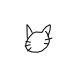

In [20]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg2/sample2.svg')

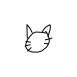

[53]

In [21]:
stroke.shape
strokes = to_big_strokes(stroke, max_len=model_params['max_seq_len']-1).tolist()
strokes.insert(0, [0, 0, 1, 0, 0])
seq_len = [len(stroke)]
draw_strokes(to_normal_strokes(np.array(strokes)))
seq_len

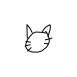

In [22]:
z = encode(stroke)


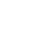

In [34]:
_ = decode(z, temperature=1.0) # convert z back to drawing at temperature of 0.8


In [45]:
# DEBUGGGG
stroke2 = np.expand_dims(strokes,axis=0)
encoder_input = stroke2[:, 0:test_set.max_seq_length+1, :]
# The target/expected vectors of strokes
target_output = encoder_input

# vectors of strokes to be fed to decoder (same as above, but lagged behind
# one step to include initial dummy value of (0, 0, 1, 0, 0))
decoder_input = stroke2[:, :test_set.max_seq_length, :]

model_args = ({'encoder_input': encoder_input, 'decoder_input': decoder_input}, {'output': target_output})
seq2seq.model.evaluate(x=model_args[0], y = model_args[1])
# encoder_input

1/1 [==============================] - 1s 824ms/step


[1.0905767679214478, 1.0789663791656494, 1.1610438823699951]

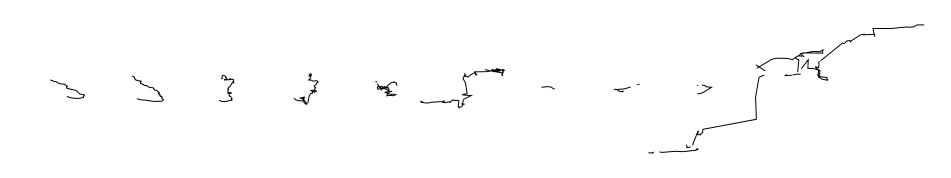

In [50]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)